In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
df = pd.read_csv('Data/insurance - insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Q1. Do smokers have higher insurance charges than non-smokers?

Null Hypothesis: Smokers and non-smokers have same insurance charges.

Alternate Hypothesis: Smokers have higher insurance charges than non-smokers.

Since there are two groups and the data is a numeric data, I'll run a 2 sample t-test.

In [2]:
smokers=df.loc[df['smoker']=='yes', 'charges']
nonsmokers=df.loc[df['smoker']=='no', 'charges']

In [3]:
smokers_outliers=np.abs(stats.zscore(smokers))>3
smokers_outliers.sum()

0

In [4]:
nonsmokers_outliers=np.abs(stats.zscore(nonsmokers))>3
nonsmokers_outliers.sum()

24

In [5]:
nonsmokers= nonsmokers.loc[~nonsmokers_outliers]

In [6]:
results = stats.normaltest(smokers)
results.pvalue

5.564930630036463e-14

In [7]:
resultn = stats.normaltest(nonsmokers)
resultn.pvalue

2.6945416315543976e-36

In [8]:
resultVar = stats.levene(smokers,nonsmokers)
print(resultVar)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


In [9]:
from scipy import stats
result1 = stats.ttest_ind(smokers, nonsmokers, equal_var=False, alternative = 'greater')
print(result1)
result1.pvalue  < .05

Ttest_indResult(statistic=33.732305987092516, pvalue=1.2876613312937155e-104)


True

In [10]:
if result1.pvalue < .05:
    print(f"The groups do NOT have equal variance.")
else:
    print(f"The groups DO have equal variance.")

The groups do NOT have equal variance.


The two groups are normal and outliers have been removed. However, since the two groups don't have equal variance, we use a Welch's test.

We had a p-value < .05 for our Welch's t-test. We reject the null hypothesis and support the alternative hypothesis that smokers have higher charges than non-smokers.

<AxesSubplot: xlabel='charges', ylabel='Density'>

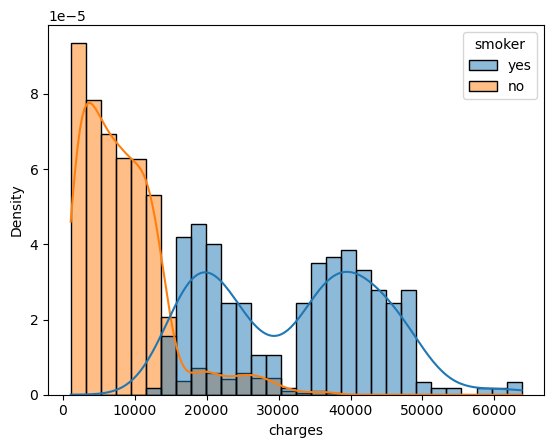

In [11]:
sns.histplot(data=df, x='charges',hue='smoker',common_norm=False,
             stat='density',kde=True)

Q2. Are men more likely to smoke than women?

Null Hypothesis: Men and women have same likelihood of smoking.

Alternate Hypothesis: Men are more likely to smoke than women.

There are two groups and this is a categorical data, therefore we'll use chi square testing.

In [12]:
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [13]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [14]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

We had a p-value < .05 for our Chi-square testing. We reject the null hypothesis and support the alternative hypothesis that men are more likely to smoke than women.

<AxesSubplot: xlabel='smoker', ylabel='Density'>

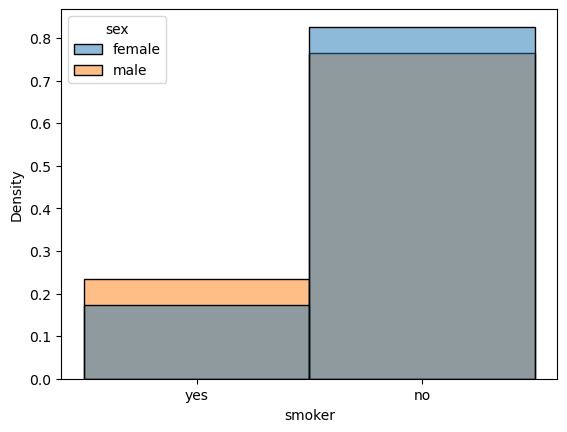

In [15]:
sns.histplot(data=df, x='smoker',hue='sex',common_norm=False,
             stat='density')

Q3. Do different regions have different charges, on average?

Null Hypothesis: Different regions have same insurance charges.

Alternate Hypothesis: Different regions have different charges.

There are 4 groups and it uses numeric data, therefore we will use ANOVA.

In [16]:
groups ={}

for area in df['region'].unique():
    temp = df.loc[df['region']== area, 'charges']
    groups[area] = temp

groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [17]:
for area, data in groups.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3

    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {area} region.")

    ## Remove the outiers from data and overwrite the sector data in the dict
    data = data.loc[~outliers]
    groups[area] = data

There were 8 outliers in the southwest region.
There were 2 outliers in the southeast region.
There were 7 outliers in the northwest region.
There were 4 outliers in the northeast region.


In [18]:
## Running normal test on each group and confirming there are >20 in each group

## Save a list with an inner list of column names
norm_results = [['group','n','pval','sig?']]


## loop through group dict
for area, data in groups.items():
    ## calculate normaltest results
    stat, p = stats.normaltest(data)

    ## Append the right info into norm_resutls (as a list)
    norm_results.append([area,len(data), p, p<.05])


## Make norm_results a dataframe (first row is columns, everything else data)
normal_results = pd.DataFrame(norm_results[1:], columns = norm_results[0])
normal_results

,group,n,pval,sig?
0,southwest,317,7.728611e-22,True
1,southeast,362,1.936990e-13,True
2,northwest,318,2.940543e-19,True
3,northeast,320,3.557877e-17,True


This shows that the groups do not have normal distribution, but our n is large enough to disregard it.

In [19]:
# with the * operator
stats.levene(*groups.values())


LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

We met the assumption of normality but did NOT meet the assumption of equal variance. We wanted to run an ANOVA test but will need to use a Kurskal-Wallis test instead.

In [20]:
result = stats.kruskal(*groups.values())
print(result)
result.pvalue<.05

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)


False

Our Kruskal Wallis test returned a p-value greater than .05. We fail to reject the null hypothesis and conclude that there is insignificant proof to say that the four groups have different charges due to their regional differences.

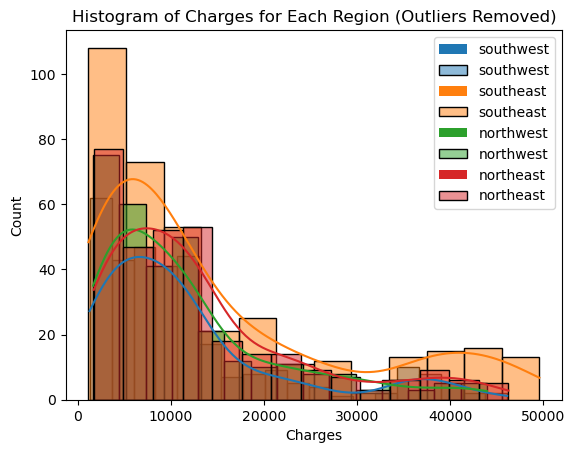

In [21]:
for area, data in groups.items():
    sns.histplot(data, kde=True, label=area)
plt.xlabel('Charges')
plt.ylabel('Count')
plt.title('Histogram of Charges for Each Region (Outliers Removed)')
plt.legend()
plt.show()